In [41]:
# Loading packages
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Dense
import h5py

%matplotlib inline

In [42]:
# Global parameters
sigsize = 1000
setsize = 5000

# Defining exponential kernel convolution function
def expconv(signal, taur, taud, time=0.4):
    '''Function that convolves signal with exponential kernel'''
    # Building exponential kernel
    tkern = np.arange(20*taud/time) * time
    expkern = np.exp(-tkern/taud) - np.exp(-tkern/taur)
    # Convolve with signal and return convolved signal of right shape
    sigout = np.convolve(signal, expkern)[0:signal.size]
    
    return sigout

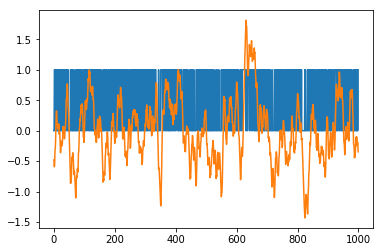

In [43]:
# First dataset to build: fixed rise and decay constants, fixed amplifying coefficient, fixed base, and no noise
taur = 1
taud = 3
a = 1
b = 0
sigma = 0
sparse = 0.3 # if random threshold is too low this could result in too many spikes
# Building dataset
Xset = np.zeros((setsize, sigsize))
Yset = np.zeros((setsize, sigsize))
for signal in range(setsize):
    # Defining spiking array using threshold
    randtemp = 0
    while randtemp < sparse:
        randtemp = np.random.random(1)
    tocrop = 500 # crop at the beginning to delete high rise
    spikes = 1 * (np.random.random(sigsize+tocrop) > randtemp) 
    cspikes = expconv(spikes, taur, taud)
    Yset[signal, :] = spikes[tocrop:]
    Xset_nomean = a*cspikes[tocrop:] + b + (sigma*np.random.randn(1, sigsize))
    Xset[signal, :] = Xset_nomean - np.mean(Xset_nomean)
plt.plot(Yset[0, :])
plt.plot(Xset[0, :])

In [44]:
# Defining Keras model
deconv_in = Input(shape=(sigsize, 1))
x = Bidirectional(LSTM(100, input_shape=(sigsize, 1), return_sequences=True))(deconv_in)
deconv_out = Dense(1, activation='sigmoid')(x)
deconv_model = Model(inputs=deconv_in, outputs=deconv_out)
deconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1000, 1)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 1000, 200)         81600     
_________________________________________________________________
dense_14 (Dense)             (None, 1000, 1)           201       
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Fit model
deconv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Xset_temp = Xset.reshape(Xset.shape[0], Xset.shape[1], 1)
Yset_temp = Yset.reshape(Yset.shape[0], Yset.shape[1], 1)
deconv_model.fit(Xset_temp, Yset_temp, batch_size=32, epochs=5)

Epoch 1/5
5000/5000 [==============================] - 69s 14ms/step - loss: 0.5635 - acc: 0.7153
Epoch 2/5
5000/5000 [==============================] - 76s 15ms/step - loss: 0.4308 - acc: 0.7977
Epoch 3/5
5000/5000 [==============================] - 68s 14ms/step - loss: 0.3392 - acc: 0.8668
Epoch 4/5
5000/5000 [==============================] - 79s 16ms/step - loss: 0.2612 - acc: 0.9198
Epoch 5/5
5000/5000 [==============================] - 69s 14ms/step - loss: 0.1639 - acc: 0.9744


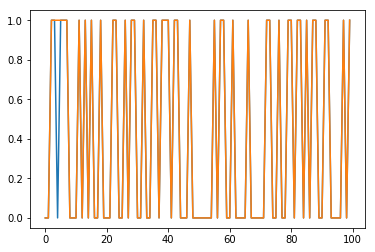

In [46]:
# Test model
deconvolved = 1 * (deconv_model.predict(Xset_temp[0, :].reshape(1, sigsize, 1)).reshape(sigsize, 1) >= 0.5)
plt.plot(Yset_temp[0, 0:100])
plt.plot(deconvolved[0:100])

Alright this works pretty weel. Now adding a bit of noise

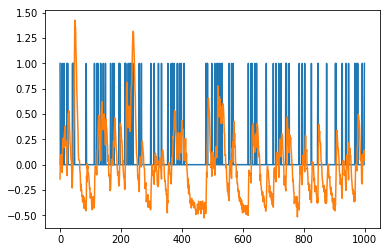

In [47]:
# First dataset to build: fixed rise and decay constants, fixed amplifying coefficient, fixed base, and small noise
taur = 1
taud = 3
a = 1
b = 0
sigma = a / 25
sparse = 0.3 # if random threshold is too low this could result in too many spikes
# Building dataset
Xset = np.zeros((setsize, sigsize))
Yset = np.zeros((setsize, sigsize))
for signal in range(setsize):
    # Defining spiking array using threshold
    randtemp = 0
    while randtemp < sparse:
        randtemp = np.random.random(1)
    tocrop = 500 # crop at the beginning to delete high rise
    spikes = 1 * (np.random.random(sigsize+tocrop) > randtemp) 
    cspikes = expconv(spikes, taur, taud)
    Yset[signal, :] = spikes[tocrop:]
    Xset_nomean = a*cspikes[tocrop:] + b + (sigma*np.random.randn(1, sigsize))
    Xset[signal, :] = Xset_nomean - np.mean(Xset_nomean)
plt.plot(Yset[0, :])
plt.plot(Xset[0, :])

In [48]:
# Defining Keras model
deconv_in = Input(shape=(sigsize, 1))
x = Bidirectional(LSTM(100, input_shape=(sigsize, 1), return_sequences=True))(deconv_in)
deconv_out = Dense(1, activation='sigmoid')(x)
deconv_model = Model(inputs=deconv_in, outputs=deconv_out)
deconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1000, 1)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 1000, 200)         81600     
_________________________________________________________________
dense_15 (Dense)             (None, 1000, 1)           201       
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Fit same model
deconv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Xset_temp = Xset.reshape(Xset.shape[0], Xset.shape[1], 1)
Yset_temp = Yset.reshape(Yset.shape[0], Yset.shape[1], 1)
deconv_model.fit(Xset_temp, Yset_temp, batch_size=32, epochs=5)

Epoch 1/5
5000/5000 [==============================] - 69s 14ms/step - loss: 0.5607 - acc: 0.7190
Epoch 2/5
5000/5000 [==============================] - 74s 15ms/step - loss: 0.4658 - acc: 0.7712
Epoch 3/5
5000/5000 [==============================] - 74s 15ms/step - loss: 0.4060 - acc: 0.8108
Epoch 4/5
5000/5000 [==============================] - 66s 13ms/step - loss: 0.3147 - acc: 0.8669
Epoch 5/5
5000/5000 [==============================] - 68s 14ms/step - loss: 0.2625 - acc: 0.8986


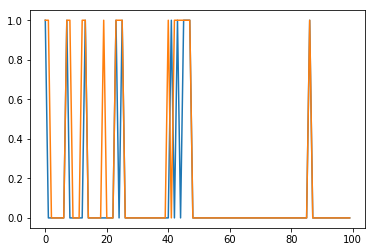

In [50]:
# Test model
deconvolved = 1 * (deconv_model.predict(Xset_temp[0, :].reshape(1, sigsize, 1)).reshape(sigsize, 1) >= 0.5)
plt.plot(Yset_temp[0, 0:100])
plt.plot(deconvolved[0:100])

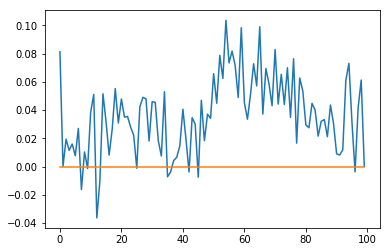

In [51]:
# Just a small test using actual data from HDF5
path = '/home/ljp/Science/Hippolyte/ALL_DATASETS/2018-05-24Run08.h5'
f = h5py.File(path, 'r')

# Get the data
data = np.array(f['/Data/Brain/Analysis/DFF'])
data_temp = data[0:sigsize, 0].T

deconvolved = 1 * (deconv_model.predict(data_temp.reshape(1, sigsize, 1)).reshape(sigsize, 1) >= 0.5)
plt.plot(data_temp[0:100])
plt.plot(deconvolved[0:100])

In [52]:
# Defining Keras model
deconv_in = Input(shape=(sigsize, 1))
x = Bidirectional(LSTM(64, input_shape=(sigsize, 1), return_sequences=True))(deconv_in)
x = Bidirectional(LSTM(128, input_shape=(sigsize, 1), return_sequences=True))(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
deconv_out = Dense(1, activation='sigmoid')(x)
deconv_model = Model(inputs=deconv_in, outputs=deconv_out)
deconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1000, 1)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 1000, 128)         33792     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 1000, 256)         263168    
_________________________________________________________________
dense_16 (Dense)             (None, 1000, 128)         32896     
_________________________________________________________________
dense_17 (Dense)             (None, 1000, 64)          8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1000, 1)           65        
Total params: 338,177
Trainable params: 338,177
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Fit model
deconv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Xset_temp = Xset.reshape(Xset.shape[0], Xset.shape[1], 1)
Yset_temp = Yset.reshape(Yset.shape[0], Yset.shape[1], 1)
deconv_model.fit(Xset_temp, Yset_temp, batch_size=32, epochs=5)

Epoch 1/5
5000/5000 [==============================] - 180s 36ms/step - loss: 0.4622 - acc: 0.7805
Epoch 2/5
5000/5000 [==============================] - 171s 34ms/step - loss: 0.1954 - acc: 0.9215
Epoch 3/5
5000/5000 [==============================] - 172s 34ms/step - loss: 0.1936 - acc: 0.9229
Epoch 4/5
5000/5000 [==============================] - 176s 35ms/step - loss: 0.1593 - acc: 0.9374
Epoch 5/5
5000/5000 [==============================] - 173s 35ms/step - loss: 0.1480 - acc: 0.9418


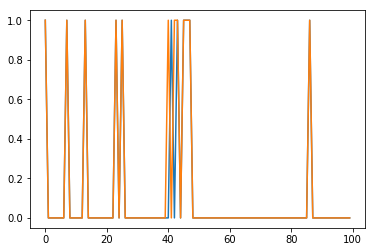

In [54]:
# Test model
deconvolved = 1 * (deconv_model.predict(Xset_temp[0, :].reshape(1, sigsize, 1)).reshape(sigsize, 1) >= 0.5)
plt.plot(Yset_temp[0, 0:100])
plt.plot(deconvolved[0:100])

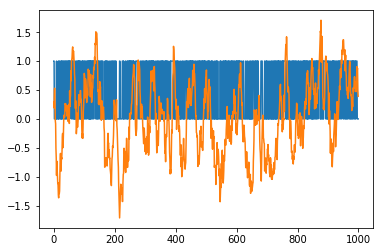

In [55]:
# First dataset to build: fixed rise and decay constants, fixed amplifying coefficient, fixed base, and medium noise
taur = 1
taud = 3
a = 1
b = 0
sigma = a / 10
sparse = 0.3 # if random threshold is too low this could result in too many spikes
# Building dataset
Xset = np.zeros((setsize, sigsize))
Yset = np.zeros((setsize, sigsize))
for signal in range(setsize):
    # Defining spiking array using threshold
    randtemp = 0
    while randtemp < sparse:
        randtemp = np.random.random(1)
    tocrop = 500 # crop at the beginning to delete high rise
    spikes = 1 * (np.random.random(sigsize+tocrop) > randtemp) 
    cspikes = expconv(spikes, taur, taud)
    Yset[signal, :] = spikes[tocrop:]
    Xset_nomean = a*cspikes[tocrop:] + b + (sigma*np.random.randn(1, sigsize))
    Xset[signal, :] = Xset_nomean - np.mean(Xset_nomean)
plt.plot(Yset[0, :])
plt.plot(Xset[0, :])

In [56]:
# Defining Keras model
deconv_in = Input(shape=(sigsize, 1))
x = Bidirectional(LSTM(64, input_shape=(sigsize, 1), return_sequences=True))(deconv_in)
x = Bidirectional(LSTM(128, input_shape=(sigsize, 1), return_sequences=True))(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
deconv_out = Dense(1, activation='sigmoid')(x)
deconv_model = Model(inputs=deconv_in, outputs=deconv_out)
deconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1000, 1)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 1000, 128)         33792     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 1000, 256)         263168    
_________________________________________________________________
dense_19 (Dense)             (None, 1000, 128)         32896     
_________________________________________________________________
dense_20 (Dense)             (None, 1000, 64)          8256      
_________________________________________________________________
dense_21 (Dense)             (None, 1000, 1)           65        
Total params: 338,177
Trainable params: 338,177
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Fit model
deconv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
Xset_temp = Xset.reshape(Xset.shape[0], Xset.shape[1], 1)
Yset_temp = Yset.reshape(Yset.shape[0], Yset.shape[1], 1)
deconv_model.fit(Xset_temp, Yset_temp, batch_size=32, epochs=5)

Epoch 1/5
5000/5000 [==============================] - 173s 35ms/step - loss: 0.5002 - acc: 0.7587
Epoch 2/5
5000/5000 [==============================] - 201s 40ms/step - loss: 0.3867 - acc: 0.8219
Epoch 3/5
5000/5000 [==============================] - 166s 33ms/step - loss: 0.3763 - acc: 0.8255
Epoch 4/5
5000/5000 [==============================] - 167s 33ms/step - loss: 0.3753 - acc: 0.8262
Epoch 5/5
5000/5000 [==============================] - 198s 40ms/step - loss: 0.3503 - acc: 0.8377


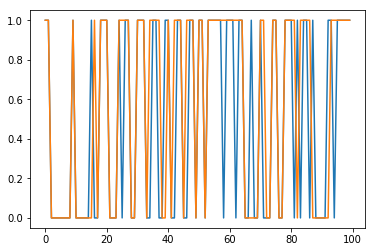

In [58]:
# Test model
deconvolved = 1 * (deconv_model.predict(Xset_temp[0, :].reshape(1, sigsize, 1)).reshape(sigsize, 1) >= 0.5)
plt.plot(Yset_temp[0, 0:100])
plt.plot(deconvolved[0:100])